In [57]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
import matplotlib.collections as mcoll
from scipy.interpolate import NearestNDInterpolator
from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from coords import *
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
from astropy.coordinates import Angle
import astropy.units as u

import lmfit
from lmfit import minimize, Minimizer, Parameters,create_params



from collections import Counter
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors


In [2]:
plt.style.use('classic')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

    

def rotate(x,y,theta):
    xprime = x*cos(theta) - y*sin(theta)
    yprime = x*sin(theta) + y*cos(theta)
    return xprime, yprime

l_offset = np.radians(-0.0558)
b_offset = np.radians(-0.0462)
x_offset = Rsun*l_offset
y_offset = Rsun*b_offset

#############################
# create class that stores a ring
#############################

class Ring:

    def __init__(self,t,a,bb,z,v0,theta,xyzsun,vxyzsun,alpha=0.4):
        self.t     = t
        self.a     = a
        self.bb     = bb
        self.z0    = z
        self.v0    = v0
        self.theta = theta
        self.x     = a*cos(t)
        self.y     = -bb*sin(t)
        self.z     = self.z0*sin(-2*t + alpha)
        self.R     = sqrt(self.x**2+self.y**2)
        self.phi   = -arctan2(self.y,self.x)
        self.ephix = -sin(self.phi) # unit vector parallel to circle
        self.ephiy = -cos(self.phi) # unit vector parallel to circle
        norm       = sqrt((a*sin(t))**2+(bb*cos(t))**2)
        self.ex    = -a*sin(t)/norm # unit vector parellel to ellipse
        self.ey    = -bb*cos(t)/norm  # unit vector parallel to ellipse
        self.cosalpha = self.ex*self.ephix + self.ey*self.ephiy
        self.vphi  = self.R[0]*self.v0/self.R # assume conservation of angular momentum
        self.v     = self.vphi/self.cosalpha # total speed along the orbit
        self.vx    = +self.v*self.ex
        self.vy    = +self.v*self.ey
        self.vz    = np.zeros(t.size)
        self.x,self.y   = rotate(self.x,self.y,theta)
        self.vx,self.vy = rotate(self.vx,self.vy,theta)
        self.X,self.Y,self.Z,self.vX,self.Vy,self.vZ = xyz2XYZ(self.x,self.y,self.z,self.vx,self.vy,self.vz,xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        # Convert Sgr A* offset from degrees to radians
        l_offset = np.radians(0.0558)
        b_offset = np.radians(-0.0462)
        x_offset = Rsun*l_offset
        y_offset = 0
        z_offset = Rsun*b_offset
        # Calculate galactic coordinates accounting for Sgr A* offset
        self.l,self.b,self.r,self.vl,self.vb,self.vr = xyz2lbr(
            self.x,self.y,self.z,self.vx,self.vy,self.vz,
            xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        self.l += l_offset
        self.b += b_offset
        self.x += x_offset
        self.y += y_offset
        self.z += z_offset
        self.mu_l, self.mu_b = vlb_2_mulb(self.r, self.vl*100, self.vb*100)
        self.mu_l, self.mu_b = vlb_2_mulb(self.r,self.vl*100,self.vb*100)

        
#############################
# define sun position & velocity
#############################

xsun  = 0.0
ysun  = -8.1
zsun  = 0.0
vxsun = -2.2
vysun = 0.0
vzsun = 0.0
xyzsun  = [xsun, ysun, zsun ]
vxyzsun = [vxsun,vysun,vzsun]
phisun  = arctan2(ysun,xsun)



In [3]:
def lb_lv_plots(Rings):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 6))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    


    ### Plot Rings LB ###
    ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)

    for i in range(0,len(cat_agg)):

        if cat_agg['NF_decision'][i] == 'N':
            ax[0].scatter(cat_agg['l'][i],cat_agg['b'][i], marker='o', c=color_list[0], s=120 )
        if cat_agg['NF_decision'][i] == 'LN':
            ax[0].scatter(cat_agg['l'][i],cat_agg['b'][i], marker='o', c=color_list[1], s=120)
        if cat_agg['NF_decision'][i] == 'U':
            ax[0].scatter(cat_agg['l'][i],cat_agg['b'][i], marker='o', c=color_list[2], s=120)
        if cat_agg['NF_decision'][i] == 'LF':
            ax[0].scatter(cat_agg['l'][i],cat_agg['b'][i], marker='o', c=color_list[3], s=120)
        if cat_agg['NF_decision'][i] == 'F':
            ax[0].scatter(cat_agg['l'][i],cat_agg['b'][i], marker='o', c=color_list[4], s=120)
        if cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(cat_agg['l'][i],cat_agg['b'][i], marker='s', s=150, edgecolor='gray', zorder=3, c='k')


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)


    ### Plot Rings LV ###
    ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(cat_tab)):

        if cat_tab['NF_decision'][i] == 'N':
            ax[1].scatter(cat_tab['l'][i],cat_tab['v'][i], marker='o', c=color_list[0], s=120 )
        if cat_tab['NF_decision'][i] == 'LN':
            ax[1].scatter(cat_tab['l'][i],cat_tab['v'][i], marker='o', c=color_list[1], s=120)
        if cat_tab['NF_decision'][i] == 'U':
            ax[1].scatter(cat_tab['l'][i],cat_tab['v'][i], marker='o', c=color_list[2], s=120)
        if cat_tab['NF_decision'][i] == 'LF':
            ax[1].scatter(cat_tab['l'][i],cat_tab['v'][i], marker='o', c=color_list[3], s=120)
        if cat_tab['NF_decision'][i] == 'F':
            ax[1].scatter(cat_tab['l'][i],cat_tab['v'][i], marker='o', c=color_list[4], s=120)
        if cat_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(cat_tab['l'][i],cat_tab['v'][i], marker='s', s=150, edgecolor='gray', zorder=3, c='k')






    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    
    ax[0].text(.95, .95, 'a = {:.3f}, b = {:.3f}'.format(Rings.a,Rings.bb), fontsize=13, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    
    plt.show()

    return 

In [4]:
def load_data(path, sep='\s+', cols=[0,1,2,3],names=['l', 'b', 'v', 'near_far']):
    return pd.read_csv(path, sep=sep, header=None, names=names)
    #lk, bk, vk, NF = data['l'].values, data['b'].values, data['v'].values, data['near_far'].values
    #return data, lk, bk, vk, NF
    #Find near and far point

In [37]:
### create a function that is a continuous distribution between NF on the ring itself
# take the y indices of the ring that are in front of the offset = Near; behind = Far
# values are relative weights in the distribution?
def ring_NF_dist(Rings):
    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<y_offset)

    y_NF =  Rings.y.copy()
    y_NF=np.where(Rings.y<y_offset,y_NF,-(Rings.y - np.nanmin(Rings.y[back_ind]) )/ (np.nanmax(Rings.y[back_ind]) - np.nanmin(Rings.y[back_ind])))
    y_NF=np.where(Rings.y>=y_offset,y_NF,(Rings.y - np.nanmin(Rings.y[fore_ind]) )/ (np.nanmax(Rings.y[fore_ind]) - np.nanmin(Rings.y[fore_ind])))
    #y_NF=np.where(Rings.y<y_offset,y_NF,-1)
    #y_NF=np.where(Rings.y>=y_offset,y_NF,1)

    return back_ind, fore_ind, y_NF

#Try this other distance metric later...
def calculate_mahalanobis_distances(data1, data2):
    cov = np.cov(data1.T)
    inv_cov = np.linalg.inv(cov)
    distances = cdist(data1, data2, metric='mahalanobis', VI=inv_cov)
    return distances, inv_cov

def normalizelbv(l,b,v):
    lmin, lmax = -0.6, 1.7
    bmin, bmax = -0.3, 0.1
    vmin, vmax = -110., 100.
    
    #using approximate extents of the data in l,b,v to normalize between -1 and 1
    norml = 2*((l - lmin) / (lmax - lmin)) -1. 
    normb = 2*((b - bmin) / (bmax - bmin)) -1. 
    normv = 2*((v - vmin) / (vmax - vmin)) -1. 
    
    return norml,normb,normv


def distancelbv4D(l, b, v, nf, l0, b0, v0, nf0):
    #typical Cartesian distance measurement 
    d_l = l - l0
    d_b = b - b0
    d_v = v - v0
    d_nf = nf - nf0
    dis = np.sqrt( d_l**2 + d_b**2 + d_v**2 + d_nf**2)
    return dis


def min_distancelbv4D(streaml, streamb, streamv,streamnf, P):
    """
    Compute minimum/a distance/s between
    a point P[x0,y0,z0] and a curve (x,y,z).
    
    Returns min indexes and distances array.
    """
    # compute distances for every point on the stream
    d = distancelbv4D(streaml, streamb, streamv, streamnf, P[0], P[1], P[2], P[3])

    # find the minima 
    glob_min_idxs = np.argwhere(d==np.min(d)).ravel()
    return glob_min_idxs, d #returns all distance values and minima index

#Gaussian function for the PPDF distributions (used in KNN search)
def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2.* (sigma**2 )))

#Save normed data as a class
class norm_data:    
    def __init__(self, norml0, normb0, normv0, NF):
        self.l0 = norml0
        self.b0 = normb0
        self.v0 = normv0
        NF = np.where(np.isnan(NF)==False, NF,99)
        self.NF = NF #Cloud NF is decided from the PPDF centers, already normalized to [-1,1]

# LMFIT time

In [105]:
###Read in data to scatter plot in lbv 
cat_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
post_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex")

##remove the rows with NaN NF decisions 
post_tab.remove_rows(np.where(cat_tab['NF_decision']=='nan'))
cat_tab.remove_rows(np.where(cat_tab['NF_decision']=='nan'))



cat_index = cat_tab['leaf_id']
cloud_name = cat_tab['cloud_name']
#l = cat_tab['l']
#b = cat_tab['b']
#v = cat_tab['v']
#sigma = cat_tab['sigma']
#rad = cat_tab['rad']
NF_decision = cat_tab['NF_decision']
lb_pixel_mask = cat_tab['lb_pixel_mask']

post_A = post_tab['A']
post_mu = post_tab['mu']
post_sigma = post_tab['sigma']



## aggregate table that pulls out the largest mask
## to represent the l,b N/F/U position

cat_group = cat_tab.group_by('lb_pixel_mask')
cat_group_mask = cat_group.groups.keys['lb_pixel_mask'] == 1

cat_agg = cat_group.groups[cat_group_mask]






In [106]:
####################################################
### Pre-process the DATA to normalize to [-1,1] ###
####################################################
norml0, normb0, normv0 = normalizelbv(cat_tab['l'],cat_tab['b'], cat_tab['v'])
Ndata = norm_data(norml0, normb0, normv0, post_tab['mu'])

In [107]:
params = create_params(a_rings={'value': 0.09   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.055  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': 0, 'max': 180, 'vary': True}
                          )

params_OFF = create_params(a_rings={'value': 0.05   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.025  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': 15, 'max': 180, 'vary': True}
                          )

In [108]:
def ring_resid4D(params, l,b,v):
    a_rings=params['a_rings']
    b_rings=params['b_rings']
    z_rings=params['z_rings']
    v_rings=params['v_rings']
    theta_rings=params['theta_rings']
    
    dphi = np.radians(0.001)
    phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
    
    Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings, np.radians(theta_rings),xyzsun,vxyzsun)
    
        
    ### Pre-process the given MODEL; normalize to [-1,1] ###
    normELL_l, normELL_b, normELL_v = normalizelbv(np.degrees(Rings.l),np.degrees(Rings.b),Rings.vr)
    back_ind, fore_ind, y_NF = ring_NF_dist(Rings) #finds the N/F on the ellipse
    Nrings = norm_data(normELL_l, normELL_b, normELL_v , y_NF)
    
    
    ### Perform KNN search on the model and find the neighbor distances and indices in the model
    nn = NearestNeighbors(n_neighbors=10, metric='minkowski')
    nn.fit(np.vstack([Nrings.l0,Nrings.b0,Nrings.v0,Nrings.NF]).T)
    distances, indices = nn.kneighbors(np.vstack([Ndata.l0,Ndata.b0,Ndata.v0, Ndata.NF]).T)
    
    
    ### for each catalogue point, find the minimum residual between pt and the ellipse
    #   and save the min to array
    min_d_list = []
    
    for i in range(len(cat_tab)):
        
        ### min distance calculation ###
        ind, vec = min_distancelbv4D(Nrings.l0, Nrings.b0, Nrings.v0, Nrings.NF,
                                     (Ndata.l0[i], Ndata.b0[i], Ndata.v0[i],Ndata.NF[i]))
        min_d_list.append(vec[ind][0])
        
    
    

    
    return min_d_list
    

In [115]:
out = minimize(ring_resid4D, params, args=(Ndata.l0,Ndata.b0,Ndata.v0))

In [116]:
out

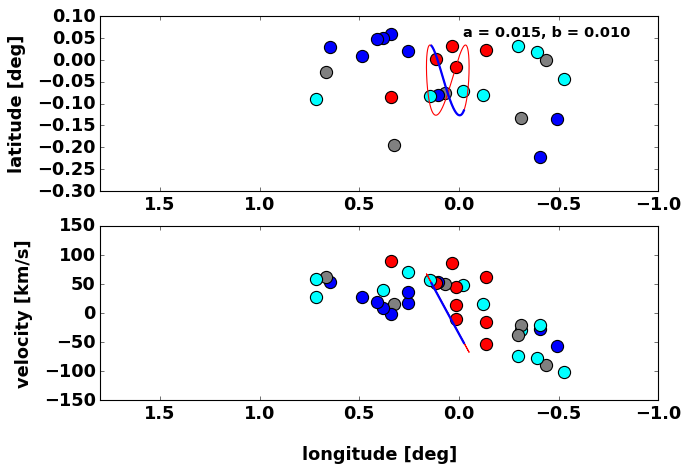

In [117]:
dphi = np.radians(0.001)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)

Rings_out = Ring(phi,
                  out.params['a_rings'].value,
                  out.params['b_rings'].value,
                  out.params['z_rings'].value,
                  out.params['v_rings'].value, 
                  np.radians(out.params['theta_rings'].value),
                  xyzsun,vxyzsun)

lb_lv_plots(Rings_out)

In [123]:
Nrings.NF

array([-0.99994214, -0.99994229, -0.99994244, ..., -0.9999417 ,
       -0.99994185, -0.999942  ])

In [121]:
Ndata.NF

array([ 0.47816568,  0.31567872, -0.04964832,  0.34971677,  0.25465074,
        0.23579568,  0.06452144, -0.11679536, -0.12046362, -0.36151239,
       -0.26997173,  1.        ,  4.27670228,  0.06383283,  0.25896966,
       -0.57380962,  4.58422449,  3.98323546,  4.55147818,  0.081467  ,
        0.37938712,  3.80322178,  0.20243351,  0.73187434,  0.74844949,
        0.6502231 ,  0.12243343,  0.56193956, -0.39541251,  0.49570645,
        0.36354467,  0.6278371 ,  0.55530144,  0.3321117 , -0.11172244,
        0.51313906,  0.41660003])

In [129]:
OG_Ring = Ring(phi,
    0.09,
    0.055,
    0.0125,
    130, 
    np.radians(25),
    xyzsun,vxyzsun)

normELL_l, normELL_b, normELL_v = normalizelbv(OG_Ring.l,OG_Ring.b,OG_Ring.vr)
back_ind, fore_ind, y_NF = ring_NF_dist(OG_Ring) #finds the N/F on the ellipse
Nrings = norm_data(normELL_l, normELL_b, normELL_v , y_NF)

In [130]:
min_d_list = []

for i in range(len(cat_tab)):

    ### min distance calculation ###
    ind, vec = min_distancelbv4D(Nrings.l0, Nrings.b0, Nrings.v0, Nrings.NF,
                                 (Ndata.l0[i], Ndata.b0[i], Ndata.v0[i],Ndata.NF[i]))
    min_d_list.append(vec[ind][0])



In [131]:
min_d_list

[0.5491660795002692,
 0.7929476253678193,
 0.3744261196945467,
 1.1943049203965,
 1.1867696154935112,
 0.3858788832701341,
 0.7119708010891252,
 0.7282856338368973,
 0.34857136765037755,
 0.5208015006776684,
 0.36268804094965545,
 0.7349471519638123,
 3.2920987528781183,
 0.4256385804172064,
 0.36544871228929465,
 0.41980859348042504,
 3.6101266964005694,
 3.069955599911356,
 3.5557312437236317,
 0.3944487541099058,
 0.4261254252119476,
 2.8277057362808797,
 0.43399286663001957,
 0.6387605918195581,
 0.4979682766081047,
 0.2603312199829033,
 1.0225453505450457,
 0.6996336003800879,
 0.5068207562310065,
 0.6306600398487652,
 0.45465374546148773,
 0.675500113431908,
 0.5875533737892338,
 0.5782118635527476,
 0.6426705877472374,
 0.8542241589525547,
 0.7676502507992646]

In [16]:
nn = NearestNeighbors(n_neighbors=10, metric='minkowski')
nn.fit(np.vstack([Nrings.l0,Nrings.b0,Nrings.v0]).T)
distances, indices = nn.kneighbors(np.vstack([Ndata.l0,Ndata.b0,Ndata.v0]).T)
predicted_nf = []
weights = []


#for j, idx, dist in zip(range(len(Ndata.l0)),indices, distances):

j=25
idx=indices[j]
dist = distances[j]
neighbors_nf = Nrings.NF[idx]
common_nf = Counter(neighbors_nf).most_common(1)[0][0]
predicted_nf.append(common_nf)


post_dist_value = gaussian(common_nf ,post_A[j],post_mu[j],post_sigma[j])

#post_weight = 
#weights.append(weight)